In [1]:
import os
from dotenv import load_dotenv
import requests
import json
from urllib.request import urlretrieve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
import pickle
import missingno as msno
from fuzzywuzzy import process

C:\Users\Brendan\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
load_dotenv()

True

*****
**Import Zillow Statistics**
*****

In [3]:
#Zillow data from .csv (pending access to API, wait time of ~10days for approval)
zillow_state_urls = {"state_hvi": "https://files.zillowstatic.com/research/public_csvs/zhvi/State_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1711137595"
}
zillow_zip_urls = {"zip_hvi": "https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1711136613"
}
zillow_metro_urls = {
    "metro_hvi": "https://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1711136613"
    ,"metro_rent": "https://files.zillowstatic.com/research/public_csvs/zori/Metro_zori_uc_sfr_sm_month.csv?t=1711136613"
    ,"metro_for_sale_inventory": "https://files.zillowstatic.com/research/public_csvs/invt_fs/Metro_invt_fs_uc_sfr_sm_month.csv?t=1711136613"
    ,"metro_new_listing": "https://files.zillowstatic.com/research/public_csvs/new_listings/Metro_new_listings_uc_sfrcondo_sm_month.csv?t=1711136613"
    ,"metro_pct_abv_list": "https://files.zillowstatic.com/research/public_csvs/pct_sold_above_list/Metro_pct_sold_above_list_uc_sfrcondo_sm_month.csv?t=1711136613"
    ,"metro_pct_blw_list": "https://files.zillowstatic.com/research/public_csvs/pct_sold_below_list/Metro_pct_sold_below_list_uc_sfrcondo_month.csv?t=1711136613"
    ,"metro_med_days_to_close": "https://files.zillowstatic.com/research/public_csvs/median_days_to_close/Metro_median_days_to_close_uc_sfrcondo_sm_month.csv?t=1711136613"
    ,"metro_pct_w_pricecut": "https://files.zillowstatic.com/research/public_csvs/perc_listings_price_cut/Metro_perc_listings_price_cut_uc_sfr_sm_month.csv?t=1711136613"
    ,"metro_new_construct": "https://files.zillowstatic.com/research/public_csvs/new_con_sales_count_raw/Metro_new_con_sales_count_raw_uc_sfr_month.csv?t=1711136613"
}

**Import: Zip code level data**

In [4]:
#Import Zillow zipcode level data from .csv (pending access to API, wait time of ~10days for approval)

dfs = []
for metric in zillow_zip_urls:
    url = zillow_zip_urls[metric]
    df_z = pd.read_csv(url) 
    df_z['metric'] = metric
    dfs.append(df_z)

zillow_zip_df = pd.concat(dfs)

zillow_zip_df['RegionName'] = zillow_zip_df['RegionName'].astype(str).str.zfill(5)

print(zillow_zip_df.iloc[:,:10].head())
zillow_zip_df = zillow_zip_df.drop(['SizeRank','StateName','City','CountyName'], axis=1)
print(zillow_zip_df.iloc[:,:6].head())
print(zillow_zip_df.iloc[:,:6].describe())
print(zillow_zip_df.info())

   RegionID  SizeRank RegionName RegionType StateName State      City  \
0     91982         1      77494        zip        TX    TX      Katy   
1     61148         2      08701        zip        NJ    NJ  Lakewood   
2     91940         3      77449        zip        TX    TX      Katy   
3     62080         4      11368        zip        NY    NY  New York   
4     91733         5      77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  210428.678988  
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  166400.359935  
2   Houston-The Woodlands-Sugar Land, TX     Harris County  103411.923516  
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  299650.138293  
4   Houston-The Woodlands-Sugar Land, TX     Harris County  102312.368944  
   RegionID RegionName RegionType State  \
0     91982      77494        zip    TX   
1     61148      08

In [5]:
#Reshape Zillow data from wide to long

zillow_zip_df_long = pd.melt(zillow_zip_df, id_vars=['RegionID','RegionName','RegionType','State','Metro','metric'])
zillow_zip_df_long["variable"] = pd.to_datetime(zillow_zip_df_long["variable"])
zillow_zip_df_long = zillow_zip_df_long.sort_values(["RegionID","variable"])
print(zillow_zip_df_long)
print(zillow_zip_df_long.describe())
print(zillow_zip_df_long.info())

         RegionID RegionName RegionType State            Metro   metric  \
7343        58196      01001        zip    MA  Springfield, MA  zip_hvi   
33585       58196      01001        zip    MA  Springfield, MA  zip_hvi   
59827       58196      01001        zip    MA  Springfield, MA  zip_hvi   
86069       58196      01001        zip    MA  Springfield, MA  zip_hvi   
112311      58196      01001        zip    MA  Springfield, MA  zip_hvi   
...           ...        ...        ...   ...              ...      ...   
7491858    808739      87547        zip    NM   Los Alamos, NM  zip_hvi   
7518100    808739      87547        zip    NM   Los Alamos, NM  zip_hvi   
7544342    808739      87547        zip    NM   Los Alamos, NM  zip_hvi   
7570584    808739      87547        zip    NM   Los Alamos, NM  zip_hvi   
7596826    808739      87547        zip    NM   Los Alamos, NM  zip_hvi   

          variable          value  
7343    2000-01-31  127822.043898  
33585   2000-02-29  127678.

In [6]:
counts = zillow_zip_df_long.groupby('RegionName')['RegionID'].nunique()
print(counts.sort_values(ascending=False))

RegionName
01001    1
61931    1
61957    1
61956    1
61953    1
        ..
32759    1
32757    1
32754    1
32751    1
99929    1
Name: RegionID, Length: 26242, dtype: int64


In [7]:
#Reshape Zillow data from long to wide for metrics
zillow_zip_df_metrics = zillow_zip_df_long.pivot_table(
    index=['RegionName','RegionType','State','Metro','variable'],
    columns='metric',
    values='value'
)
zillow_zip_df_metrics = zillow_zip_df_metrics.reset_index()
zillow_zip_df_metrics.sort_values(by='variable',inplace=True)
print(zillow_zip_df_metrics)
print(zillow_zip_df_metrics.describe())
print(zillow_zip_df_metrics.info())

metric  RegionName RegionType State                                    Metro  \
0            01001        zip    MA                          Springfield, MA   
929603       16443        zip    PA                                 Erie, PA   
2997697      55079        zip    MN  Minneapolis-St. Paul-Bloomington, MN-WI   
3740832      75230        zip    TX          Dallas-Fort Worth-Arlington, TX   
929313       16442        zip    PA                                 Erie, PA   
...            ...        ...   ...                                      ...   
4481611      93955        zip    CA                              Salinas, CA   
138144       02842        zip    RI                Providence-Warwick, RI-MA   
2036614      35824        zip    AL                           Huntsville, AL   
2036283      35811        zip    AL                           Huntsville, AL   
4840899      99901        zip    AK                            Ketchikan, AK   

metric    variable        zip_hvi  
0  

<Axes: >

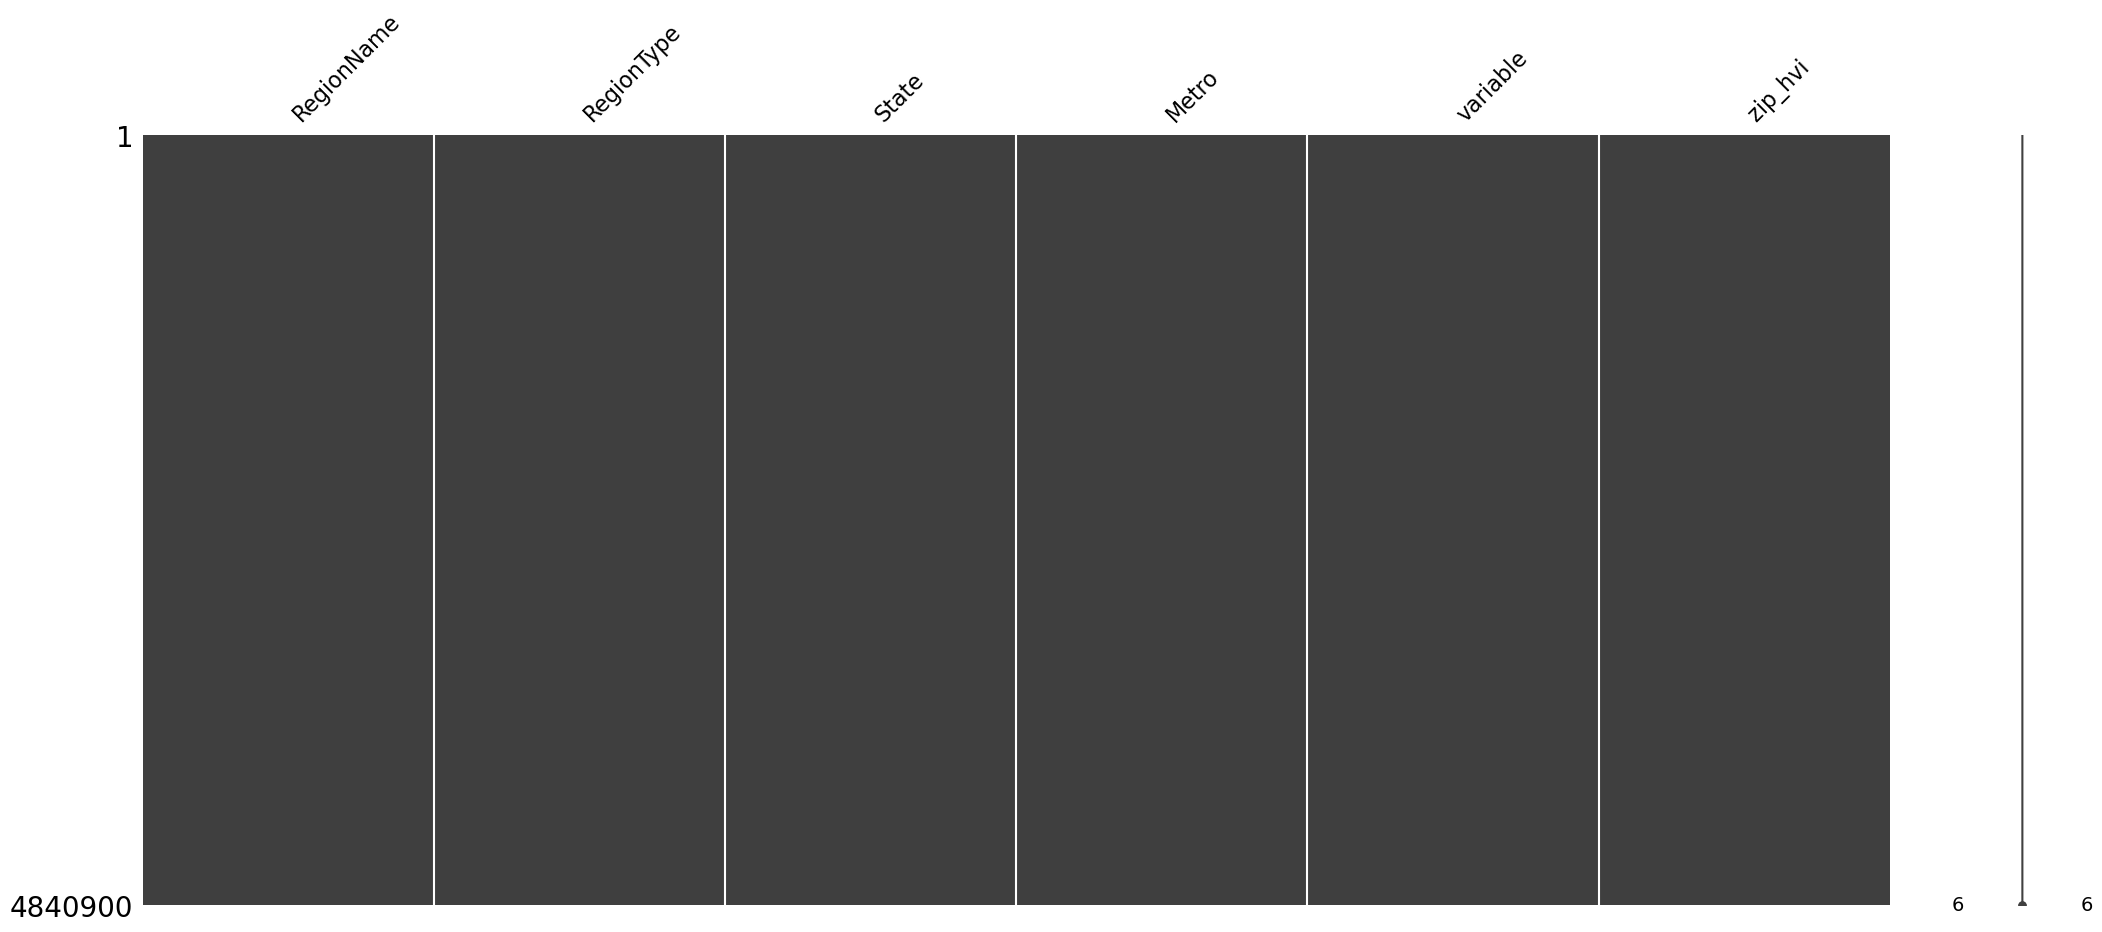

In [8]:
msno.matrix(zillow_zip_df_metrics)

**Import: Metro level data**

In [9]:
#Import Zillow metro level data from .csv (pending access to API, wait time of ~10days for approval)

dfs = []
for metric in zillow_metro_urls:
    url = zillow_metro_urls[metric]
    df_z = pd.read_csv(url) 
    df_z['metric'] = metric
    dfs.append(df_z)

zillow_metro_df = pd.concat(dfs)
    
print(zillow_metro_df.iloc[:,:6].head())
zillow_metro_df = zillow_metro_df.drop(['SizeRank'], axis=1)
print(zillow_metro_df.iloc[:,:5].head())
print(zillow_metro_df.iloc[:,:5].describe())
print(zillow_metro_df.info())

   RegionID  SizeRank       RegionName RegionType StateName     2000-01-31
0    102001         0    United States    country       NaN  120155.724910
1    394913         1     New York, NY        msa        NY  214310.236010
2    753899         2  Los Angeles, CA        msa        CA  235063.293630
3    394463         3      Chicago, IL        msa        IL  153867.253335
4    394514         4       Dallas, TX        msa        TX  127001.406363
   RegionID       RegionName RegionType StateName     2000-01-31
0    102001    United States    country       NaN  120155.724910
1    394913     New York, NY        msa        NY  214310.236010
2    753899  Los Angeles, CA        msa        CA  235063.293630
3    394463      Chicago, IL        msa        IL  153867.253335
4    394514       Dallas, TX        msa        TX  127001.406363
            RegionID     2000-01-31
count    5930.000000     431.000000
mean   419260.987858  108197.516799
std     95341.850198   51415.296981
min    102001.00

In [10]:
#Reshape Zillow data from wide to long for dates

zillow_metro_df_long = pd.melt(zillow_metro_df, id_vars=['RegionID','RegionName','RegionType','StateName','metric'])
zillow_metro_df_long["variable"] = pd.to_datetime(zillow_metro_df_long["variable"])
zillow_metro_df_long = zillow_metro_df_long.sort_values(["RegionID","variable"])
print(zillow_metro_df_long)
print(zillow_metro_df_long.describe())
print(zillow_metro_df_long.info())

         RegionID     RegionName RegionType StateName  \
0          102001  United States    country       NaN   
895        102001  United States    country       NaN   
1370       102001  United States    country       NaN   
2298       102001  United States    country       NaN   
3222       102001  United States    country       NaN   
...           ...            ...        ...       ...   
1710898    845172   Winfield, KS        msa        KS   
1713307    845172   Winfield, KS        msa        KS   
1715900    845172   Winfield, KS        msa        KS   
1716828    845172   Winfield, KS        msa        KS   
1719237    845172   Winfield, KS        msa        KS   

                           metric   variable          value  
0                       metro_hvi 2000-01-31  120155.724910  
895                    metro_rent 2000-01-31            NaN  
1370     metro_for_sale_inventory 2000-01-31            NaN  
2298            metro_new_listing 2000-01-31            NaN  
3222 

In [11]:
#Reshape Zillow data from long to wide for metrics
zillow_metro_df_metrics = zillow_metro_df_long.pivot_table(
    index=['RegionID','RegionName','RegionType','StateName','variable'],
    columns='metric',
    values='value'
)
zillow_metro_df_metrics = zillow_metro_df_metrics.reset_index()
zillow_metro_df_metrics["RegionID"] = zillow_metro_df_metrics["RegionID"].astype(str)
zillow_metro_df_metrics.sort_values(by='variable',inplace=True)
print(zillow_metro_df_metrics)
print(zillow_metro_df_metrics.describe())
print(zillow_metro_df_metrics.info())

metric RegionID       RegionName RegionType StateName   variable  \
11422    394352      Augusta, GA        msa        GA 2000-01-31   
7549     394336      Ardmore, OK        msa        OK 2000-01-31   
84158    394703  Idaho Falls, ID        msa        ID 2000-01-31   
182464   395164      Trenton, NJ        msa        NJ 2000-01-31   
71289    394635    Goldsboro, NC        msa        NC 2000-01-31   
...         ...              ...        ...       ...        ...   
58117    394570         Enid, OK        msa        OK 2024-02-29   
32230    394449       Celina, OH        msa        OH 2024-02-29   
49411    394530       Denver, CO        msa        CO 2024-02-29   
121783   394882   Moses Lake, WA        msa        WA 2024-02-29   
211529   845172     Winfield, KS        msa        KS 2024-02-29   

metric  metro_for_sale_inventory      metro_hvi  metro_med_days_to_close  \
11422                        NaN   92354.410567                      NaN   
7549                         Na

<Axes: >

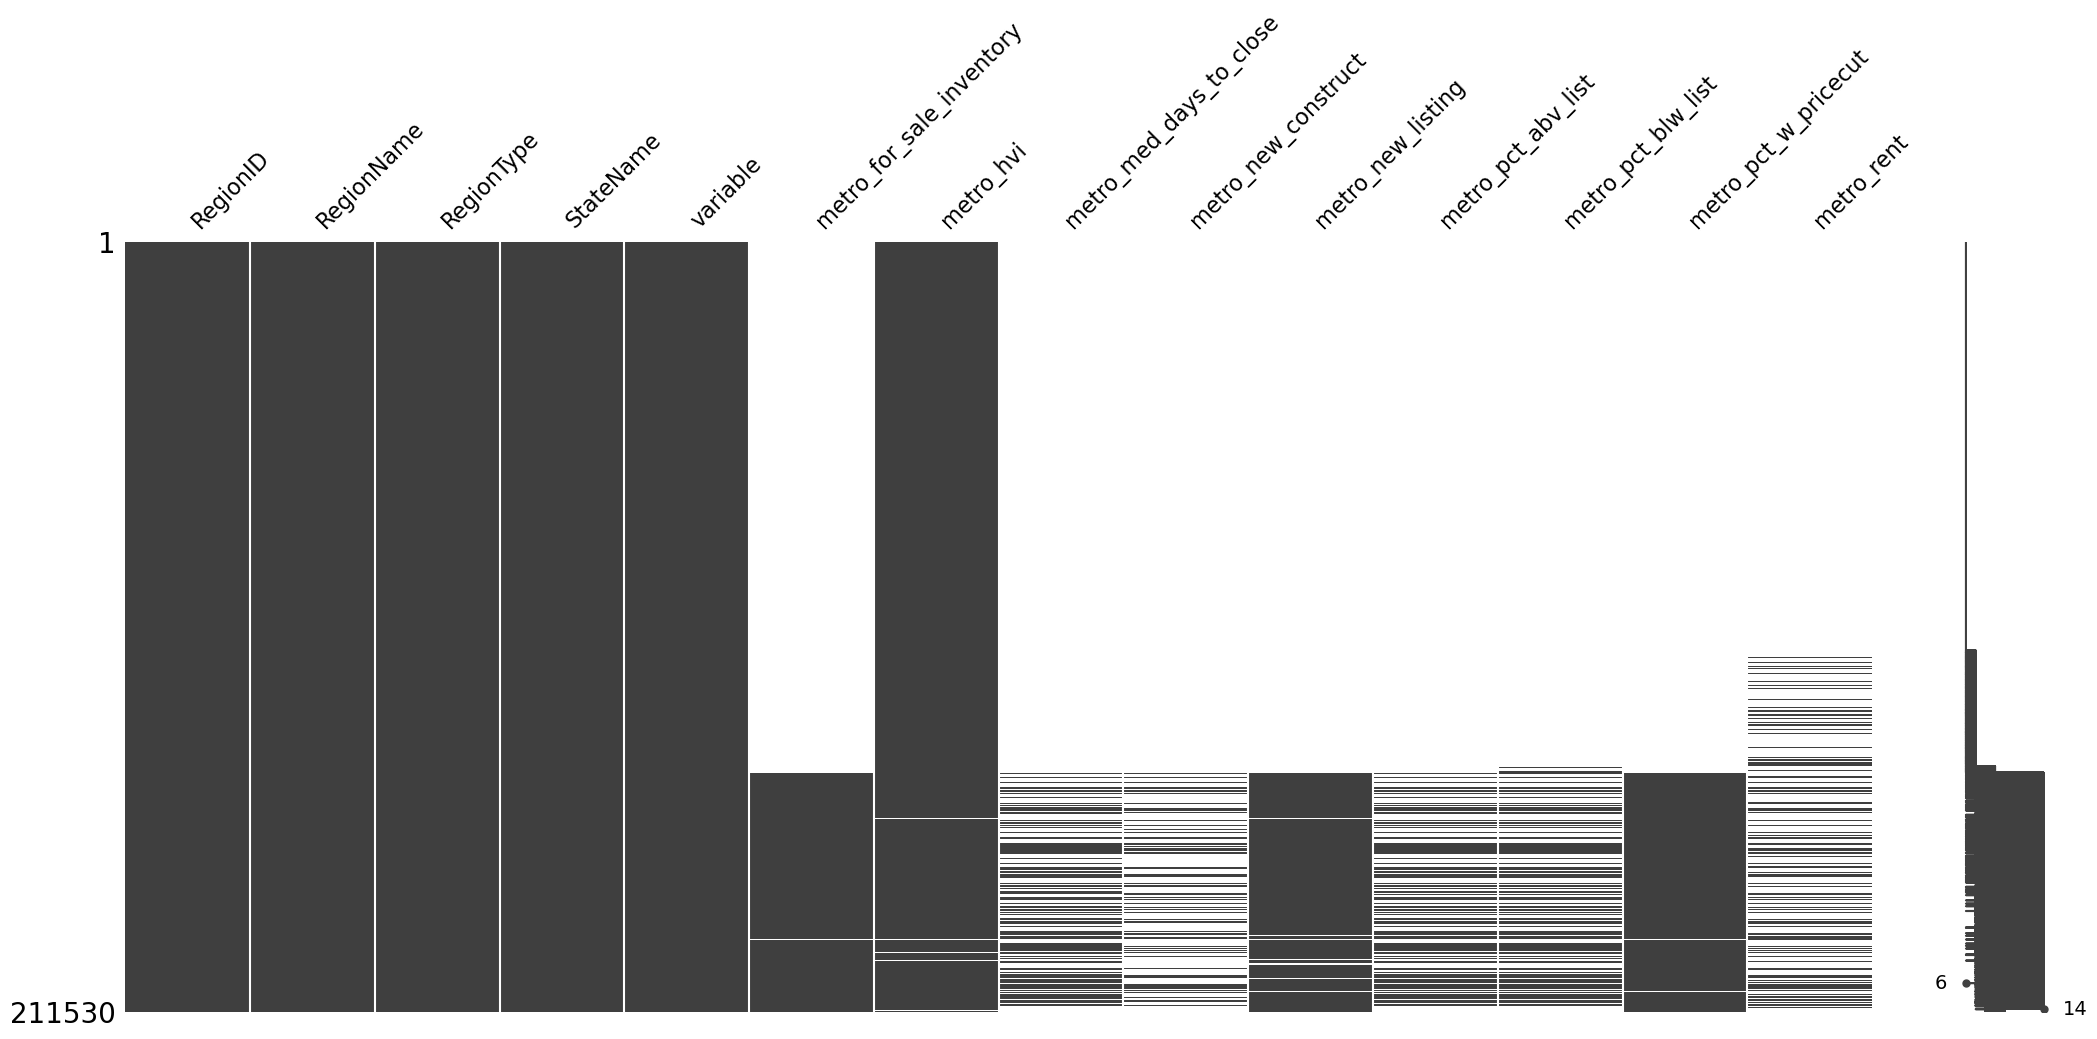

In [12]:
msno.matrix(zillow_metro_df_metrics)

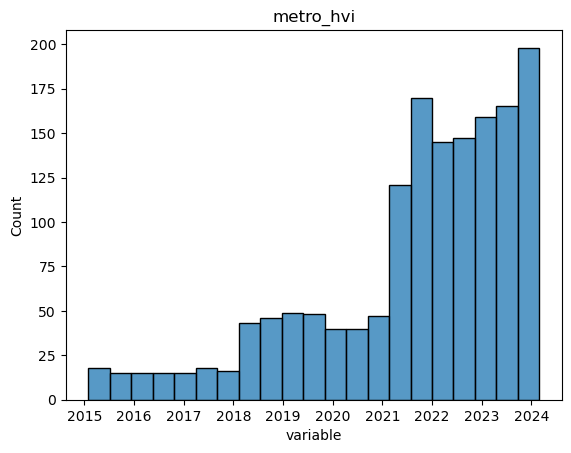

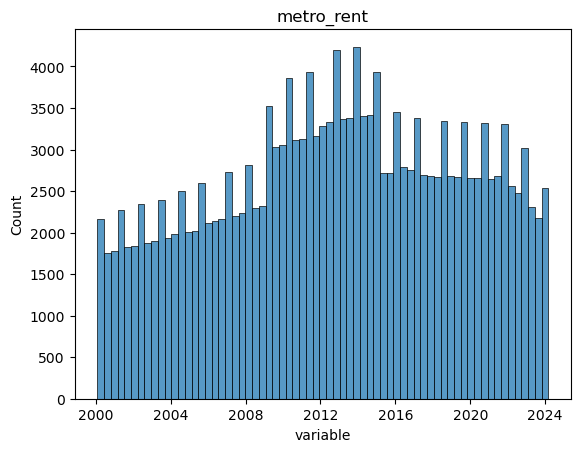

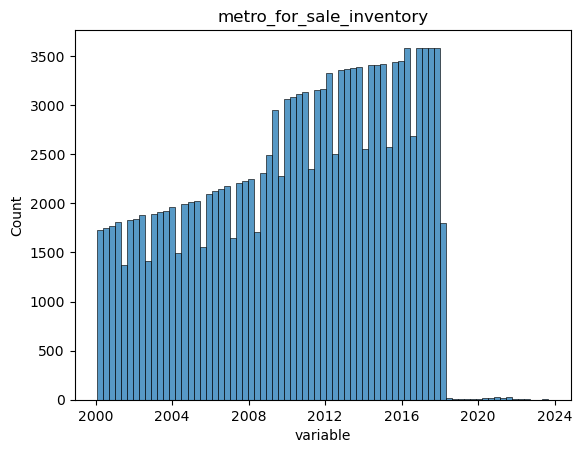

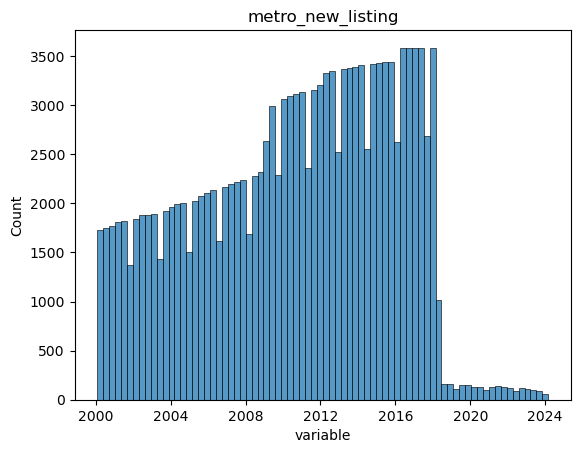

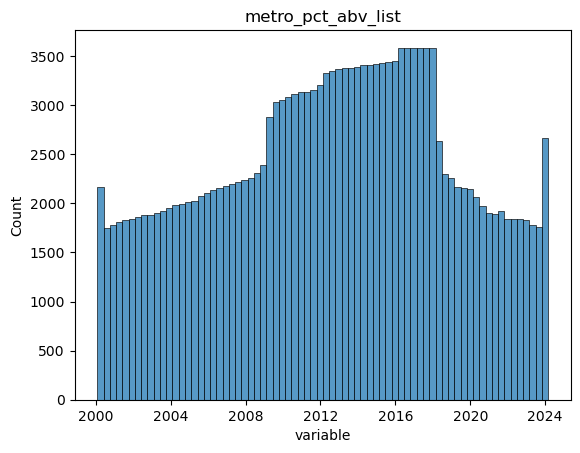

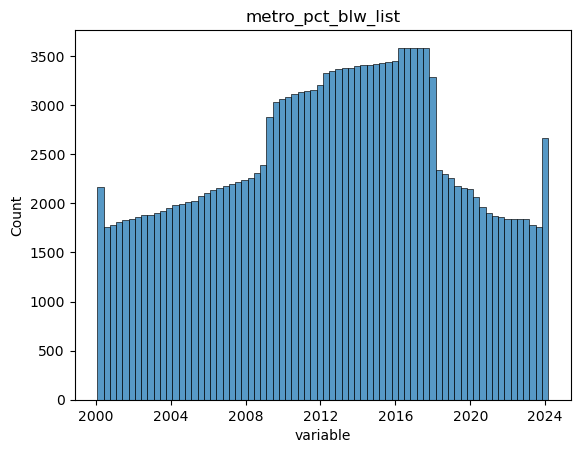

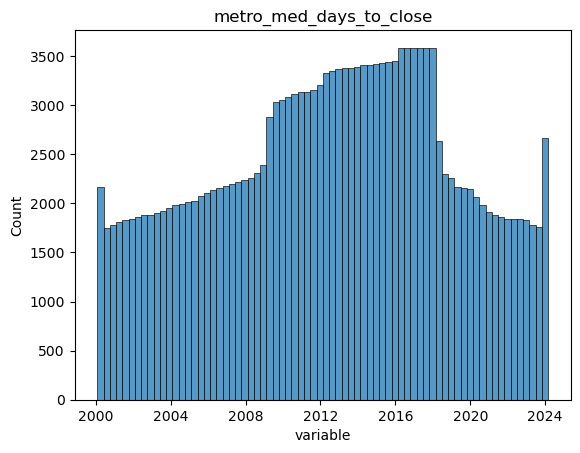

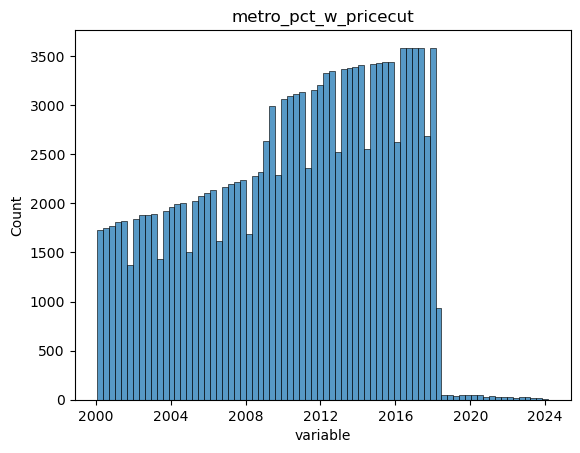

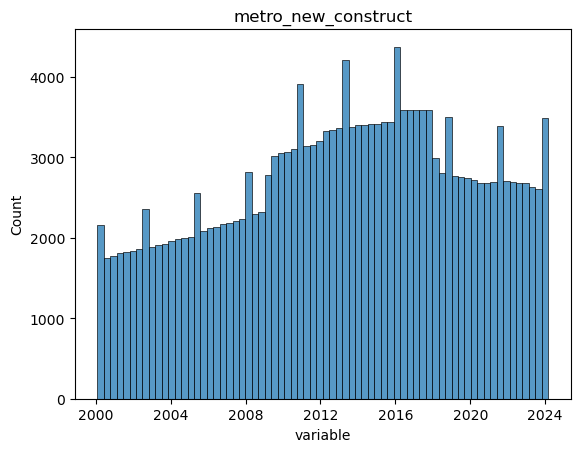

In [13]:
metro_metrics = [x for x in zillow_metro_urls]
metro_metrics


for i, x in enumerate(zillow_metro_urls):
    missing = zillow_metro_df_metrics[zillow_metro_df_metrics[x].isnull()]
    #miss_min = missing['variable'].min()
    #miss_max = missing['variable'].max()
    #print("Min: ",x,"| ",miss_min)
    #print("Max: ",x,"| ",miss_max)
    
    plt.figure(i)
    sns.histplot(x='variable', multiple="stack", data=missing).set(title=x)

plt.show()

**Import: State level data**

In [14]:
#Create dictionary from state name to abbreviation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [15]:
#Import Zillow state level HVI data from .csv (pending access to API, wait time of ~10days for approval)

url = zillow_state_urls['state_hvi']
zillow_state_df = pd.read_csv(url)
print(zillow_state_df.iloc[:,:6].head())
print(zillow_state_df.iloc[:,:6].describe())
print(zillow_state_df.info())
zillow_state_df = zillow_state_df.drop(['SizeRank','StateName'], axis=1)
zillow_state_df['metric'] = 'state_hvi'
print(zillow_state_df.iloc[:,:4].head())

   RegionID  SizeRank    RegionName RegionType  StateName     2000-01-31
0         9         0    California      state        NaN  194240.160016
1        54         1         Texas      state        NaN  110748.637816
2        14         2       Florida      state        NaN  112101.832371
3        43         3      New York      state        NaN  135831.109981
4        47         4  Pennsylvania      state        NaN   97016.762082
        RegionID   SizeRank  StateName     2000-01-31
count  51.000000  51.000000        0.0      47.000000
mean   33.137255  25.431373        NaN  126989.850297
std    17.260382  15.297392        NaN   35351.180315
min     3.000000   0.000000        NaN   71188.755978
25%    19.500000  12.500000        NaN  102655.501032
50%    34.000000  25.000000        NaN  121194.100631
75%    46.500000  38.500000        NaN  148163.380810
max    62.000000  51.000000        NaN  222134.039663
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Column

In [16]:
zillow_state_df['State'] = zillow_state_df['RegionName'].map(us_state_to_abbrev)
zillow_state_df = zillow_state_df.drop(['RegionID'], axis=1)

In [17]:
#Reshape Zillow data from wide to long

zillow_state_df_long = pd.melt(zillow_state_df, id_vars=['State','RegionName','RegionType','metric'])
zillow_state_df_long["variable"] = pd.to_datetime(zillow_state_df_long["variable"])
zillow_state_df_long = zillow_state_df_long.sort_values(["variable","State"])
zillow_state_df_long = zillow_state_df_long.rename(columns={'value':'state_HVI'})
print(zillow_state_df_long)
print(zillow_state_df_long.describe())
print(zillow_state_df_long.info())

      State     RegionName RegionType     metric   variable      state_HVI
47       AK         Alaska      state  state_hvi 2000-01-31  132714.910837
23       AL        Alabama      state  state_hvi 2000-01-31   96628.198952
32       AR       Arkansas      state  state_hvi 2000-01-31   84910.409215
13       AZ        Arizona      state  state_hvi 2000-01-31  137268.507535
0        CA     California      state  state_hvi 2000-01-31  194240.160016
...     ...            ...        ...        ...        ...            ...
14788    VT        Vermont      state  state_hvi 2024-02-29  375942.749111
14751    WA     Washington      state  state_hvi 2024-02-29  589807.142218
14758    WI      Wisconsin      state  state_hvi 2024-02-29  289235.878479
14777    WV  West Virginia      state  state_hvi 2024-02-29  155333.089031
14789    WY        Wyoming      state  state_hvi 2024-02-29  333745.049940

[14790 rows x 6 columns]
                            variable     state_HVI
count                  

<Axes: >

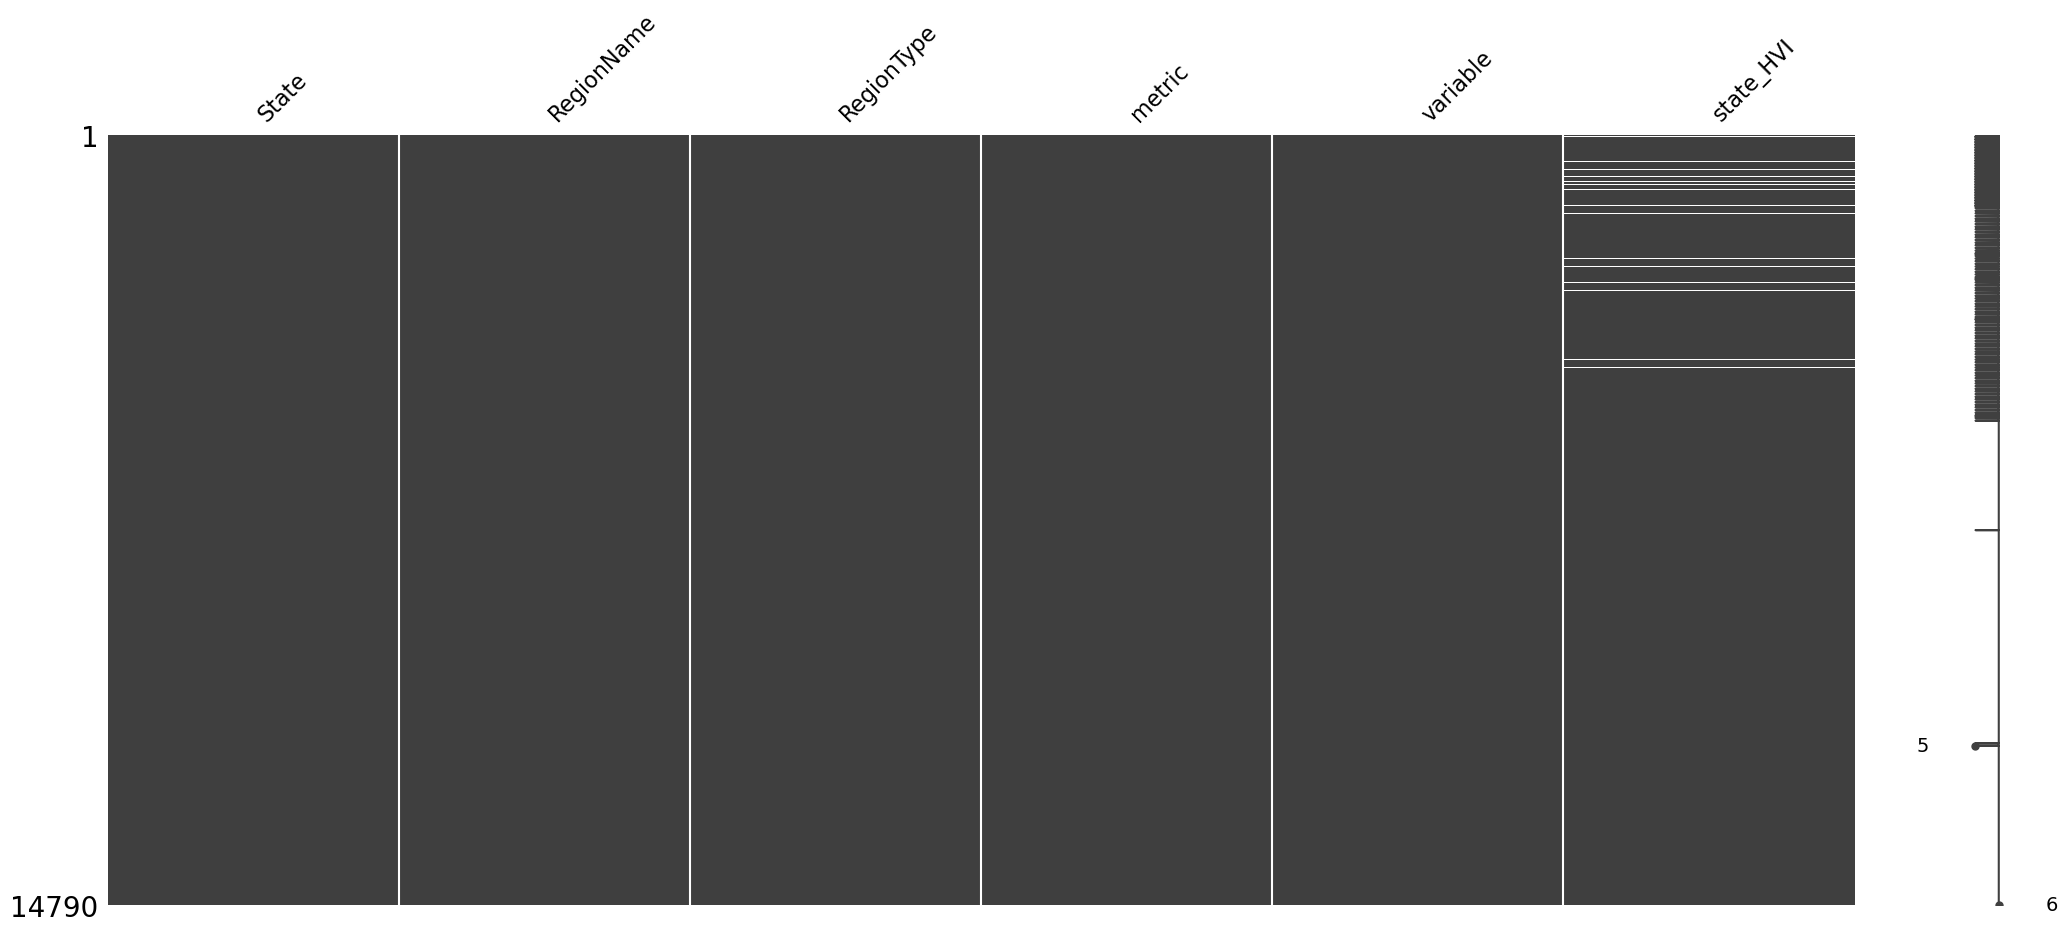

In [18]:
msno.matrix(zillow_state_df_long)

*****
**Profile Datasets**
*****

In [19]:
zillow_zip_df_metrics

metric,RegionName,RegionType,State,Metro,variable,zip_hvi
0,01001,zip,MA,"Springfield, MA",2000-01-31,127822.043898
929603,16443,zip,PA,"Erie, PA",2000-01-31,102618.733479
2997697,55079,zip,MN,"Minneapolis-St. Paul-Bloomington, MN-WI",2000-01-31,123910.805725
3740832,75230,zip,TX,"Dallas-Fort Worth-Arlington, TX",2000-01-31,435144.974587
929313,16442,zip,PA,"Erie, PA",2000-01-31,93975.688482
...,...,...,...,...,...,...
4481611,93955,zip,CA,"Salinas, CA",2024-02-29,778627.708779
138144,02842,zip,RI,"Providence-Warwick, RI-MA",2024-02-29,676483.479906
2036614,35824,zip,AL,"Huntsville, AL",2024-02-29,375196.987010
2036283,35811,zip,AL,"Huntsville, AL",2024-02-29,273604.376189


In [20]:
zillow_metro_df_metrics

metric,RegionID,RegionName,RegionType,StateName,variable,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent
11422,394352,"Augusta, GA",msa,GA,2000-01-31,NaN,92354.410567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7549,394336,"Ardmore, OK",msa,OK,2000-01-31,NaN,59406.621121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84158,394703,"Idaho Falls, ID",msa,ID,2000-01-31,NaN,110105.707149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182464,395164,"Trenton, NJ",msa,NJ,2000-01-31,NaN,149353.207744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71289,394635,"Goldsboro, NC",msa,NC,2000-01-31,NaN,80500.374823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58117,394570,"Enid, OK",msa,OK,2024-02-29,209.0,126096.926262,NaN,NaN,55.0,NaN,NaN,0.218566,1012.182540
32230,394449,"Celina, OH",msa,OH,2024-02-29,54.0,235043.141808,NaN,NaN,22.0,NaN,NaN,0.158683,NaN
49411,394530,"Denver, CO",msa,CO,2024-02-29,6229.0,603712.726465,NaN,NaN,2381.0,NaN,NaN,0.200446,2822.521369
121783,394882,"Moses Lake, WA",msa,WA,2024-02-29,168.0,346635.240079,NaN,NaN,33.0,NaN,NaN,0.133441,1797.500000


In [21]:
#Confirm all dates are end of month
list(zillow_metro_df_metrics['variable'].unique())

[Timestamp('2000-01-31 00:00:00'),
 Timestamp('2000-02-29 00:00:00'),
 Timestamp('2000-03-31 00:00:00'),
 Timestamp('2000-04-30 00:00:00'),
 Timestamp('2000-05-31 00:00:00'),
 Timestamp('2000-06-30 00:00:00'),
 Timestamp('2000-07-31 00:00:00'),
 Timestamp('2000-08-31 00:00:00'),
 Timestamp('2000-09-30 00:00:00'),
 Timestamp('2000-10-31 00:00:00'),
 Timestamp('2000-11-30 00:00:00'),
 Timestamp('2000-12-31 00:00:00'),
 Timestamp('2001-01-31 00:00:00'),
 Timestamp('2001-02-28 00:00:00'),
 Timestamp('2001-03-31 00:00:00'),
 Timestamp('2001-04-30 00:00:00'),
 Timestamp('2001-05-31 00:00:00'),
 Timestamp('2001-06-30 00:00:00'),
 Timestamp('2001-07-31 00:00:00'),
 Timestamp('2001-08-31 00:00:00'),
 Timestamp('2001-09-30 00:00:00'),
 Timestamp('2001-10-31 00:00:00'),
 Timestamp('2001-11-30 00:00:00'),
 Timestamp('2001-12-31 00:00:00'),
 Timestamp('2002-01-31 00:00:00'),
 Timestamp('2002-02-28 00:00:00'),
 Timestamp('2002-03-31 00:00:00'),
 Timestamp('2002-04-30 00:00:00'),
 Timestamp('2002-05-

In [22]:
zillow_state_df_metrics = zillow_state_df_long.drop(columns='metric')
zillow_state_df_metrics

,State,RegionName,RegionType,variable,state_HVI
47,AK,Alaska,state,2000-01-31,132714.910837
23,AL,Alabama,state,2000-01-31,96628.198952
32,AR,Arkansas,state,2000-01-31,84910.409215
13,AZ,Arizona,state,2000-01-31,137268.507535
0,CA,California,state,2000-01-31,194240.160016
...,...,...,...,...,...
14788,VT,Vermont,state,2024-02-29,375942.749111
14751,WA,Washington,state,2024-02-29,589807.142218
14758,WI,Wisconsin,state,2024-02-29,289235.878479
14777,WV,West Virginia,state,2024-02-29,155333.089031


In [23]:
review = zillow_state_df_metrics[zillow_state_df_metrics['state_HVI'].isnull()]
print(review['variable'].max())

2019-03-31 00:00:00


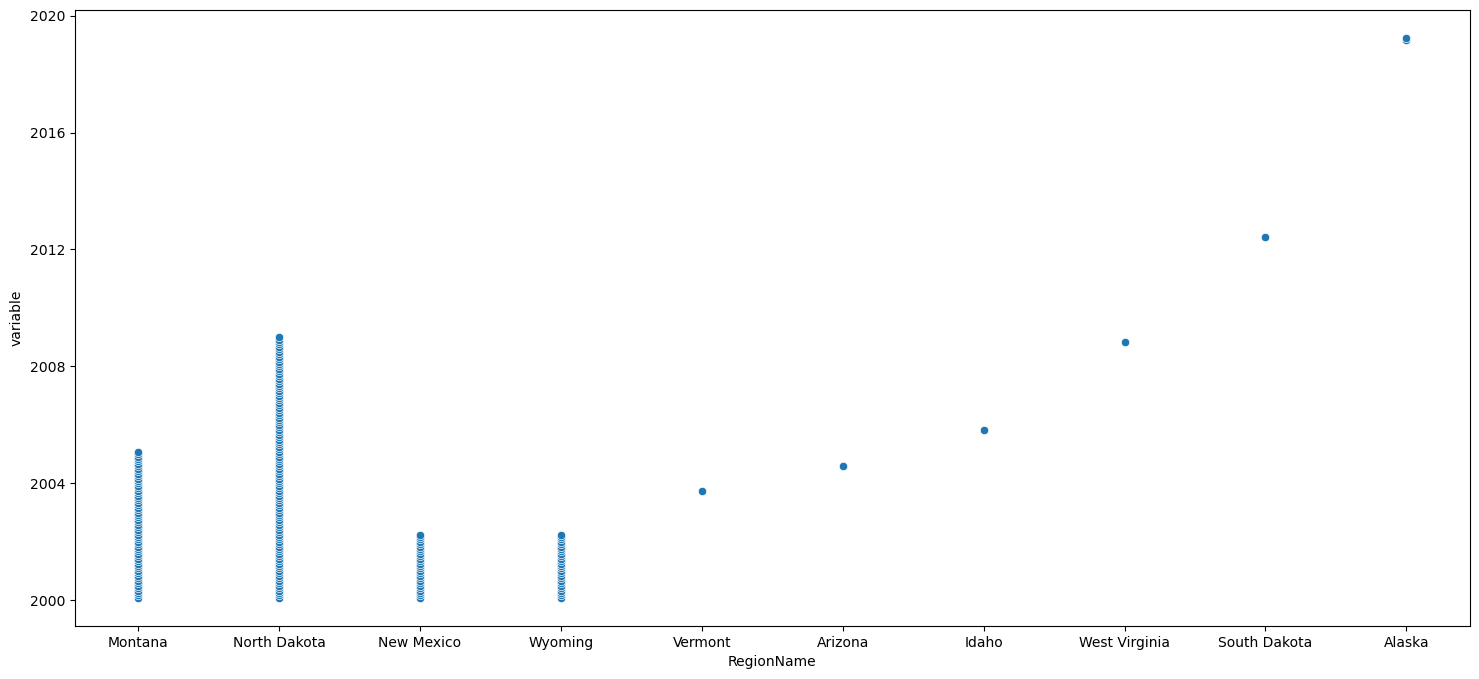

In [24]:
#sporadic missing values identified. Will keep these records.
plt.figure(figsize=(18,8))
sns.scatterplot(x="RegionName", y="variable", data=review)
plt.show()

In [25]:
#Cache premerged datasets
zillow_zip_df_metrics.to_pickle('../Data/zillow_zip_cache.pkl')
zillow_metro_df_metrics.to_pickle('../Data/zillow_metro_cache.pkl')
zillow_state_df_metrics.to_pickle('../Data/zillow_state_cache.pkl')

**Merge datasets**

In [26]:
#Add state metrics to zip dataset
zillow_zip_state = pd.merge(zillow_zip_df_metrics,zillow_state_df_metrics,on=['State','variable'],how='left')

In [27]:
print("original zip record count:",len(zillow_zip_df_metrics))
print("original state record count:",len(zillow_state_df_metrics))
print("Zip record still same after left join?:",len(zillow_zip_df_metrics) == len(zillow_zip_state))
zillow_zip_state

original zip record count: 4840900
original state record count: 14790
Zip record still same after left join?: True


,RegionName_x,RegionType_x,State,Metro,variable,zip_hvi,RegionName_y,RegionType_y,state_HVI
0,01001,zip,MA,"Springfield, MA",2000-01-31,127822.043898,Massachusetts,state,197923.616291
1,16443,zip,PA,"Erie, PA",2000-01-31,102618.733479,Pennsylvania,state,97016.762082
2,55079,zip,MN,"Minneapolis-St. Paul-Bloomington, MN-WI",2000-01-31,123910.805725,Minnesota,state,124622.947109
3,75230,zip,TX,"Dallas-Fort Worth-Arlington, TX",2000-01-31,435144.974587,Texas,state,110748.637816
4,16442,zip,PA,"Erie, PA",2000-01-31,93975.688482,Pennsylvania,state,97016.762082
...,...,...,...,...,...,...,...,...,...
4840895,93955,zip,CA,"Salinas, CA",2024-02-29,778627.708779,California,state,785293.817183
4840896,02842,zip,RI,"Providence-Warwick, RI-MA",2024-02-29,676483.479906,Rhode Island,state,448778.336935
4840897,35824,zip,AL,"Huntsville, AL",2024-02-29,375196.987010,Alabama,state,217960.518841
4840898,35811,zip,AL,"Huntsville, AL",2024-02-29,273604.376189,Alabama,state,217960.518841


In [28]:
zillow_zip_state_clean = zillow_zip_state.rename(columns={
    "RegionName_x":"zip_ID",
    "RegionType_x":"zip_type",
    "State":"state_ID",
    "RegionName_y":"state_name",
    "RegionType_y":"state_type",
})

zillow_zip_state_clean.sort_values(by=['variable','state_ID','zip_ID'], inplace=True)
zillow_zip_state_clean

,zip_ID,zip_type,state_ID,Metro,variable,zip_hvi,state_name,state_type,state_HVI
6452,99501,zip,AK,"Anchorage, AK",2000-01-31,1.435977e+05,Alaska,state,132714.910837
6110,99502,zip,AK,"Anchorage, AK",2000-01-31,1.461615e+05,Alaska,state,132714.910837
7115,99503,zip,AK,"Anchorage, AK",2000-01-31,1.166383e+05,Alaska,state,132714.910837
7392,99504,zip,AK,"Anchorage, AK",2000-01-31,1.277984e+05,Alaska,state,132714.910837
7020,99507,zip,AK,"Anchorage, AK",2000-01-31,1.483951e+05,Alaska,state,132714.910837
...,...,...,...,...,...,...,...,...,...
4820397,82945,zip,WY,"Rock Springs, WY",2024-02-29,7.062383e+04,Wyoming,state,333745.049940
4820807,83001,zip,WY,"Jackson, WY-ID",2024-02-29,2.348668e+06,Wyoming,state,333745.049940
4820838,83013,zip,WY,"Jackson, WY-ID",2024-02-29,1.550382e+06,Wyoming,state,333745.049940
4820826,83014,zip,WY,"Jackson, WY-ID",2024-02-29,4.363572e+06,Wyoming,state,333745.049940


<Axes: >

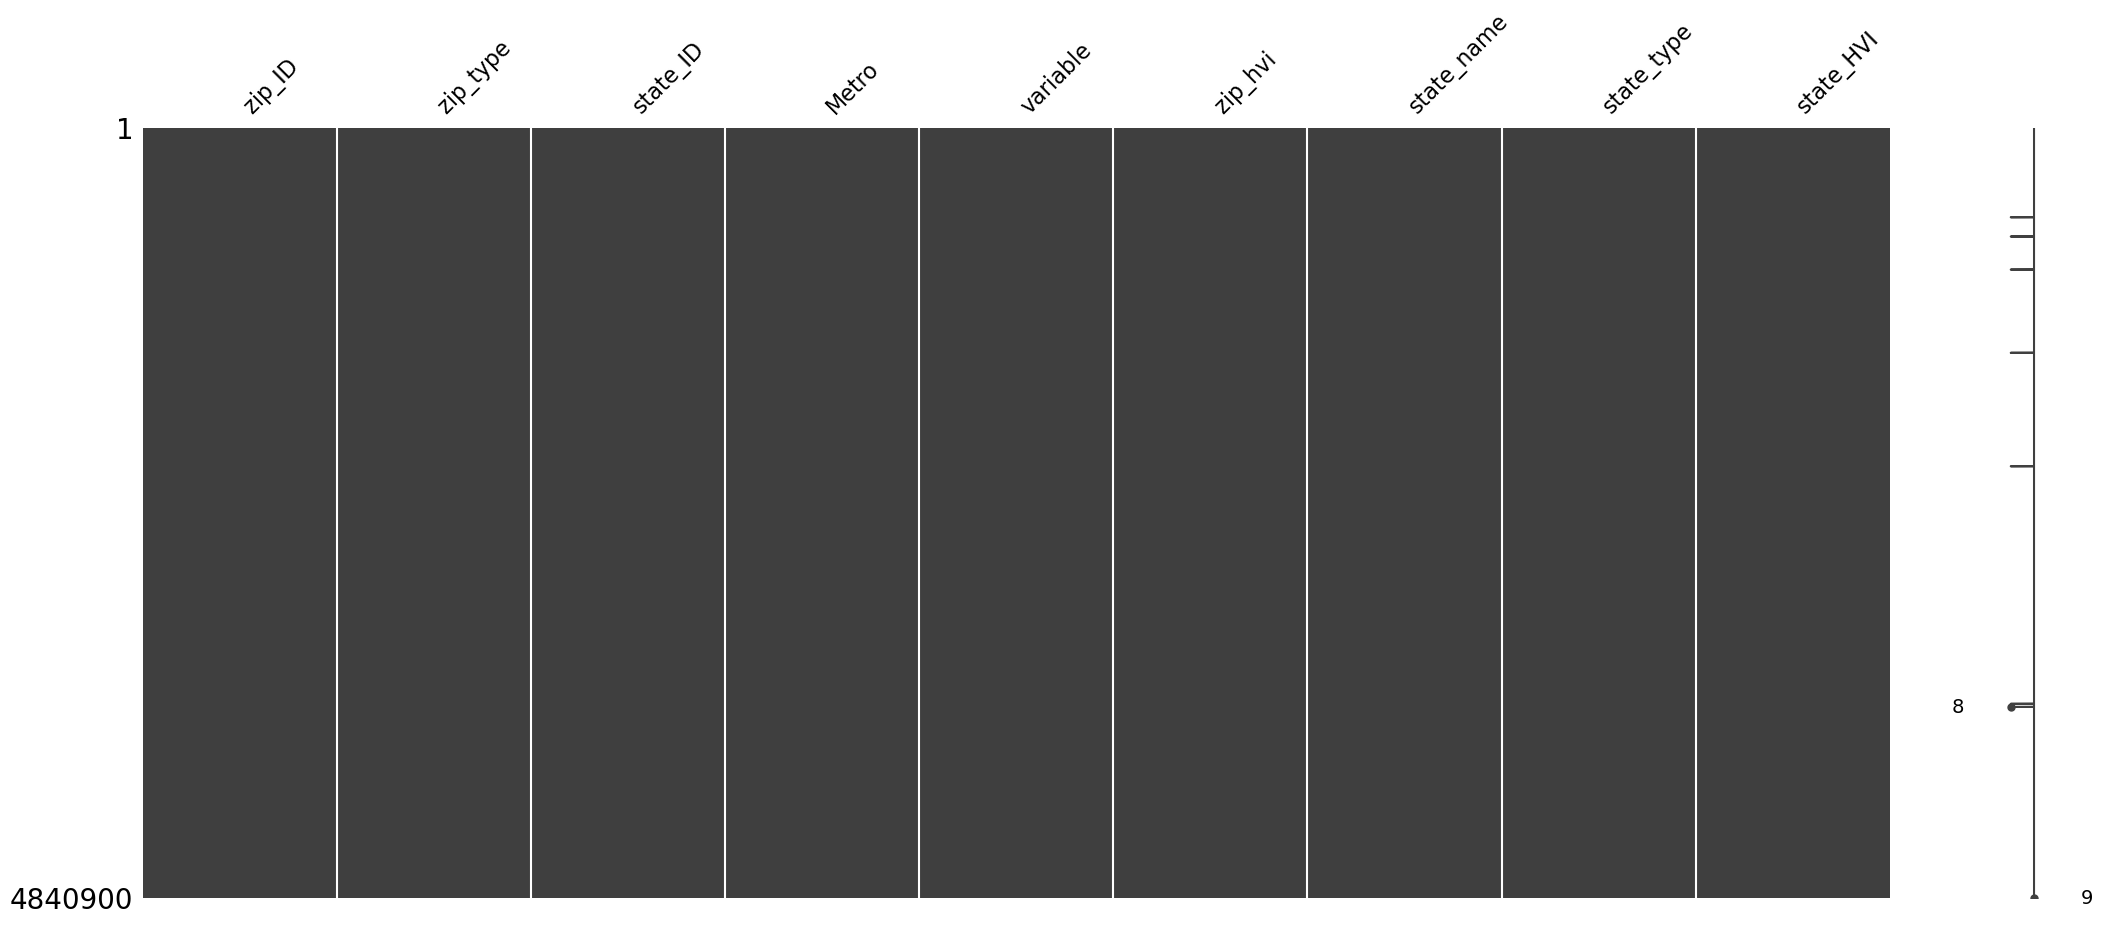

In [29]:
#review missing values
msno.matrix(zillow_zip_state_clean)

In [30]:
#Add combined state/zip metrics to metro dataset
zillow_metro_state_zip = pd.merge(zillow_zip_state_clean,zillow_metro_df_metrics,left_on=['Metro','variable'],right_on=['RegionName','variable'],how='left')

In [31]:
print("original zip record count:",len(zillow_zip_df_metrics))
print("original metro record count:",len(zillow_metro_df_metrics))
print("Zip record still same after left join?:",len(zillow_zip_df_metrics) == len(zillow_metro_state_zip))
zillow_metro_state_zip

original zip record count: 4840900
original metro record count: 211530
Zip record still same after left join?: True


,zip_ID,zip_type,state_ID,Metro,variable,zip_hvi,state_name,state_type,state_HVI,RegionID,...,StateName,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent
0,99501,zip,AK,"Anchorage, AK",2000-01-31,1.435977e+05,Alaska,state,132714.910837,394327,...,AK,NaN,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99502,zip,AK,"Anchorage, AK",2000-01-31,1.461615e+05,Alaska,state,132714.910837,394327,...,AK,NaN,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99503,zip,AK,"Anchorage, AK",2000-01-31,1.166383e+05,Alaska,state,132714.910837,394327,...,AK,NaN,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,99504,zip,AK,"Anchorage, AK",2000-01-31,1.277984e+05,Alaska,state,132714.910837,394327,...,AK,NaN,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,99507,zip,AK,"Anchorage, AK",2000-01-31,1.483951e+05,Alaska,state,132714.910837,394327,...,AK,NaN,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840895,82945,zip,WY,"Rock Springs, WY",2024-02-29,7.062383e+04,Wyoming,state,333745.049940,395032,...,WY,100.0,265160.322571,NaN,NaN,22.0,NaN,NaN,0.152154,NaN
4840896,83001,zip,WY,"Jackson, WY-ID",2024-02-29,2.348668e+06,Wyoming,state,333745.049940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4840897,83013,zip,WY,"Jackson, WY-ID",2024-02-29,1.550382e+06,Wyoming,state,333745.049940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4840898,83014,zip,WY,"Jackson, WY-ID",2024-02-29,4.363572e+06,Wyoming,state,333745.049940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
zillow_metro_state_zip_temp = zillow_metro_state_zip.drop(columns=['StateName', 'RegionName'])
zillow_metro_state_zip_clean = zillow_metro_state_zip_temp.rename(columns={
    "Metro":"metro_name",
    "RegionID":"metro_ID",
    "variable":"period",
    "RegionType":"metro_type"
})
zillow_metro_state_zip_clean.sort_values(by=['period','state_ID','metro_name','zip_ID'], inplace=True)
zillow_metro_state_zip_clean = zillow_metro_state_zip_clean.reset_index()
zillow_metro_state_zip_clean = zillow_metro_state_zip_clean[[
    'zip_ID', 'zip_type', 'state_ID', 'state_name', 'state_type', 'metro_ID', 'metro_name', 'metro_type', 'period', 
    'zip_hvi', 'state_HVI', 'metro_hvi',
    'metro_new_construct', 'metro_new_listing', 'metro_for_sale_inventory', 'metro_rent', 
    'metro_med_days_to_close', 'metro_pct_abv_list', 'metro_pct_blw_list', 'metro_pct_w_pricecut'
]]
zillow_metro_state_zip_clean

,zip_ID,zip_type,state_ID,state_name,state_type,metro_ID,metro_name,metro_type,period,zip_hvi,state_HVI,metro_hvi,metro_new_construct,metro_new_listing,metro_for_sale_inventory,metro_rent,metro_med_days_to_close,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut
0,99501,zip,AK,Alaska,state,394327,"Anchorage, AK",msa,2000-01-31,143597.651680,132714.910837,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99502,zip,AK,Alaska,state,394327,"Anchorage, AK",msa,2000-01-31,146161.464449,132714.910837,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99503,zip,AK,Alaska,state,394327,"Anchorage, AK",msa,2000-01-31,116638.267029,132714.910837,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,99504,zip,AK,Alaska,state,394327,"Anchorage, AK",msa,2000-01-31,127798.357542,132714.910837,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,99507,zip,AK,Alaska,state,394327,"Anchorage, AK",msa,2000-01-31,148395.120638,132714.910837,136485.429863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840895,82835,zip,WY,Wyoming,state,395093,"Sheridan, WY",msa,2024-02-29,495683.950116,333745.049940,405603.147283,NaN,26.0,156.0,NaN,NaN,NaN,NaN,0.087569
4840896,82836,zip,WY,Wyoming,state,395093,"Sheridan, WY",msa,2024-02-29,420965.803039,333745.049940,405603.147283,NaN,26.0,156.0,NaN,NaN,NaN,NaN,0.087569
4840897,82838,zip,WY,Wyoming,state,395093,"Sheridan, WY",msa,2024-02-29,508341.691422,333745.049940,405603.147283,NaN,26.0,156.0,NaN,NaN,NaN,NaN,0.087569
4840898,82839,zip,WY,Wyoming,state,395093,"Sheridan, WY",msa,2024-02-29,387465.652652,333745.049940,405603.147283,NaN,26.0,156.0,NaN,NaN,NaN,NaN,0.087569


In [33]:
zillow_metro_state_zip_clean.describe()

,period,zip_hvi,state_HVI,metro_hvi,metro_new_construct,metro_new_listing,metro_for_sale_inventory,metro_rent,metro_med_days_to_close,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut
count,4840900,4.840900e+06,4.840335e+06,1.880887e+06,225759.000000,618778.000000,623693.000000,384406.000000,363788.000000,363907.000000,372756.000000,623096.000000
mean,2013-04-11 01:16:56.543204096,2.515707e+05,2.257680e+05,1.741563e+05,88.745862,427.233315,1182.379135,1408.221175,36.048116,0.307847,0.511186,0.167953
min,2000-01-31 00:00:00,2.835763e+03,7.118581e+04,2.431348e+04,5.000000,3.000000,4.000000,554.927100,7.000000,0.000000,0.082569,0.009804
25%,2007-09-30 00:00:00,1.188636e+05,1.423518e+05,1.118073e+05,24.000000,66.000000,230.000000,1089.828363,31.000000,0.190021,0.398964,0.129480
50%,2013-10-31 00:00:00,1.803283e+05,1.931897e+05,1.462928e+05,49.000000,165.000000,522.000000,1297.655963,35.000000,0.283466,0.515588,0.163955
75%,2019-02-28 00:00:00,2.929241e+05,2.693065e+05,2.020940e+05,111.000000,495.000000,1321.000000,1597.712403,39.000000,0.400628,0.626050,0.202143
max,2024-02-29 00:00:00,1.246036e+07,1.001997e+06,1.559215e+06,831.000000,3564.000000,11721.000000,32730.186840,78.000000,0.822222,0.969697,0.483076
std,NaN,2.569616e+05,1.179652e+05,1.035026e+05,106.170627,627.794051,1699.512887,760.253243,7.743517,0.151430,0.157588,0.053277


In [34]:
print(zillow_metro_state_zip_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4840900 entries, 0 to 4840899
Data columns (total 20 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   zip_ID                    object        
 1   zip_type                  object        
 2   state_ID                  object        
 3   state_name                object        
 4   state_type                object        
 5   metro_ID                  object        
 6   metro_name                object        
 7   metro_type                object        
 8   period                    datetime64[ns]
 9   zip_hvi                   float64       
 10  state_HVI                 float64       
 11  metro_hvi                 float64       
 12  metro_new_construct       float64       
 13  metro_new_listing         float64       
 14  metro_for_sale_inventory  float64       
 15  metro_rent                float64       
 16  metro_med_days_to_close   float64       
 17  metro_pc

In [35]:
zillow_metro_state_zip_clean.count()

zip_ID                      4840900
zip_type                    4840900
state_ID                    4840900
state_name                  4840900
state_type                  4840900
metro_ID                    1890373
metro_name                  4840900
metro_type                  1890373
period                      4840900
zip_hvi                     4840900
state_HVI                   4840335
metro_hvi                   1880887
metro_new_construct          225759
metro_new_listing            618778
metro_for_sale_inventory     623693
metro_rent                   384406
metro_med_days_to_close      363788
metro_pct_abv_list           363907
metro_pct_blw_list           372756
metro_pct_w_pricecut         623096
dtype: int64

<Axes: >

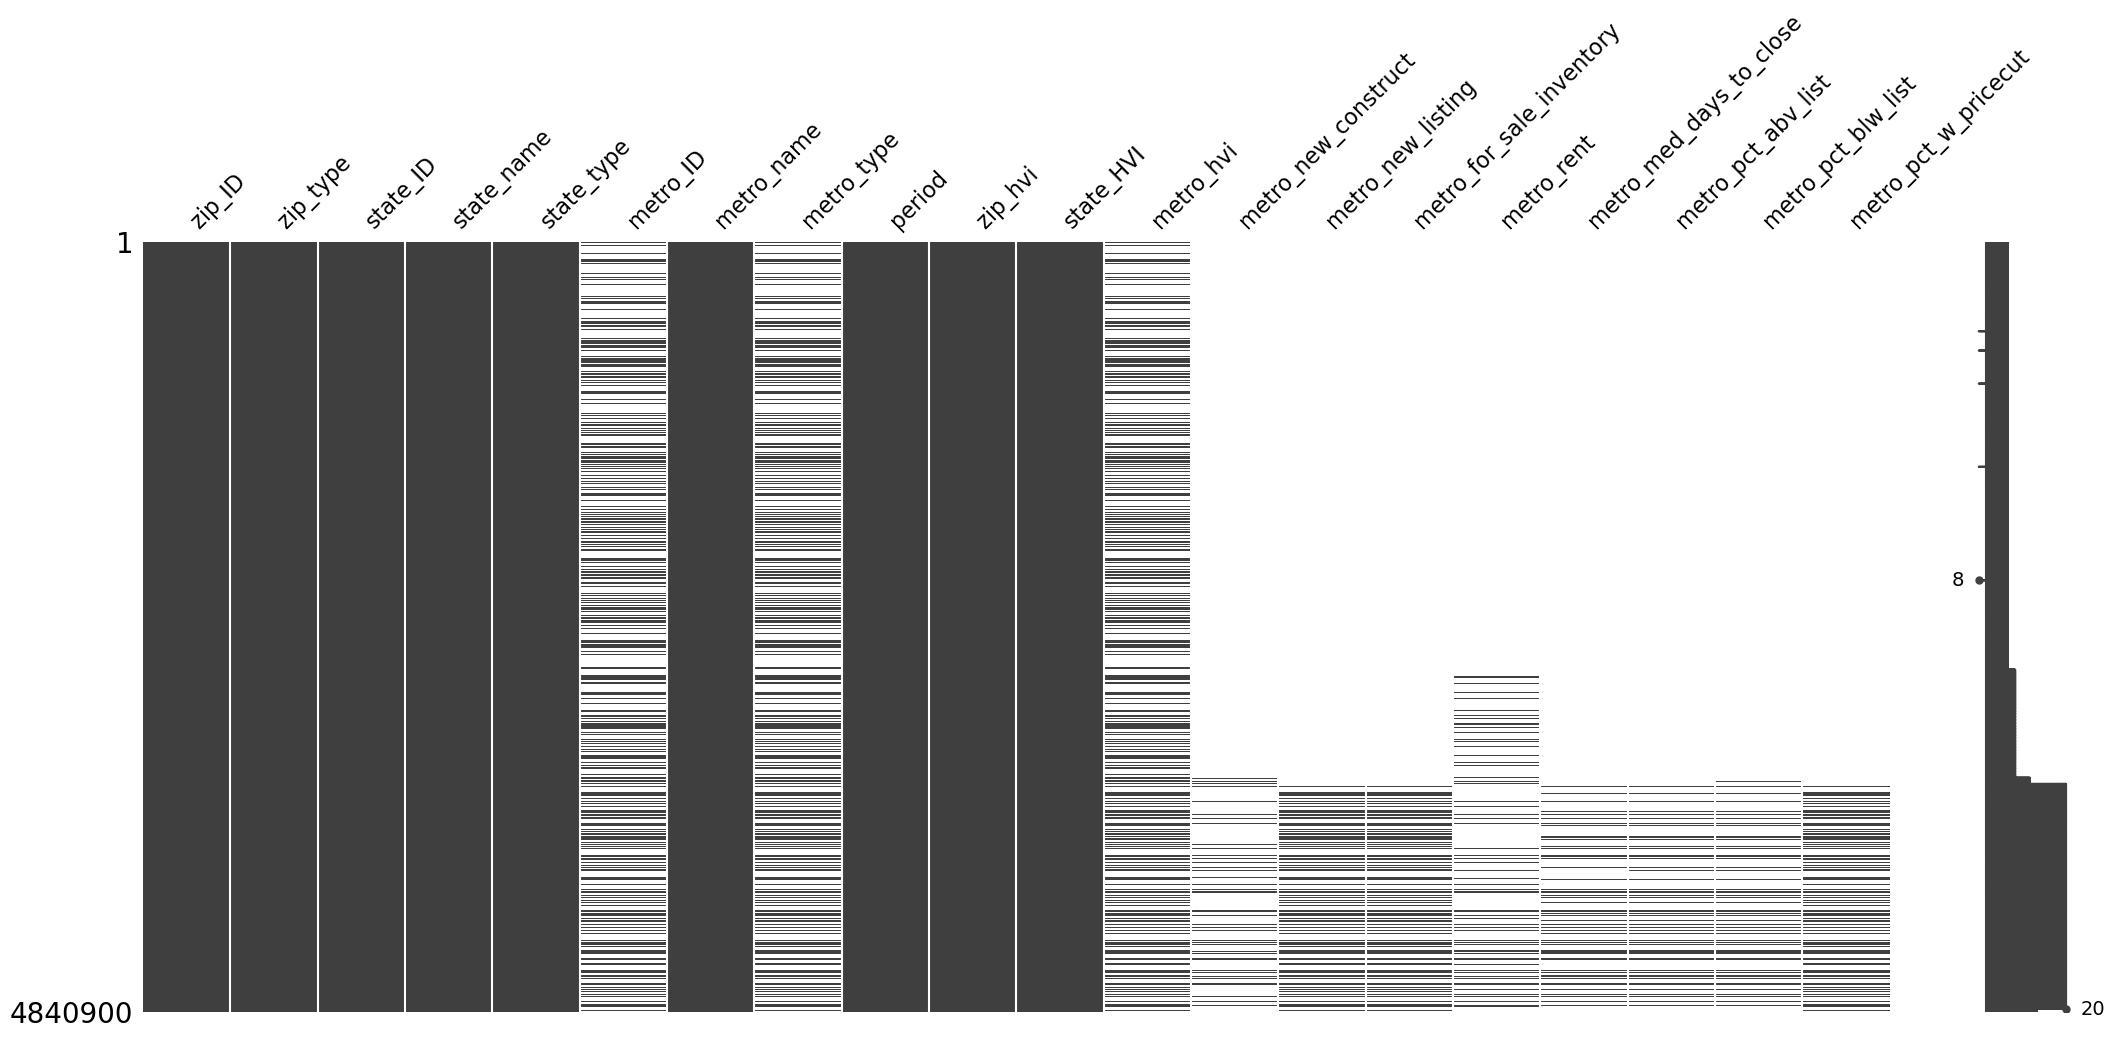

In [36]:
#review missing values
msno.matrix(zillow_metro_state_zip_clean)

In [37]:
no_metro = zillow_metro_state_zip_clean['metro_ID'].isna()
no_metro_df = pd.DataFrame(zillow_metro_state_zip_clean[no_metro])
metro_df = pd.DataFrame(zillow_metro_state_zip_clean[~no_metro])

No metro
Metro


<Axes: >

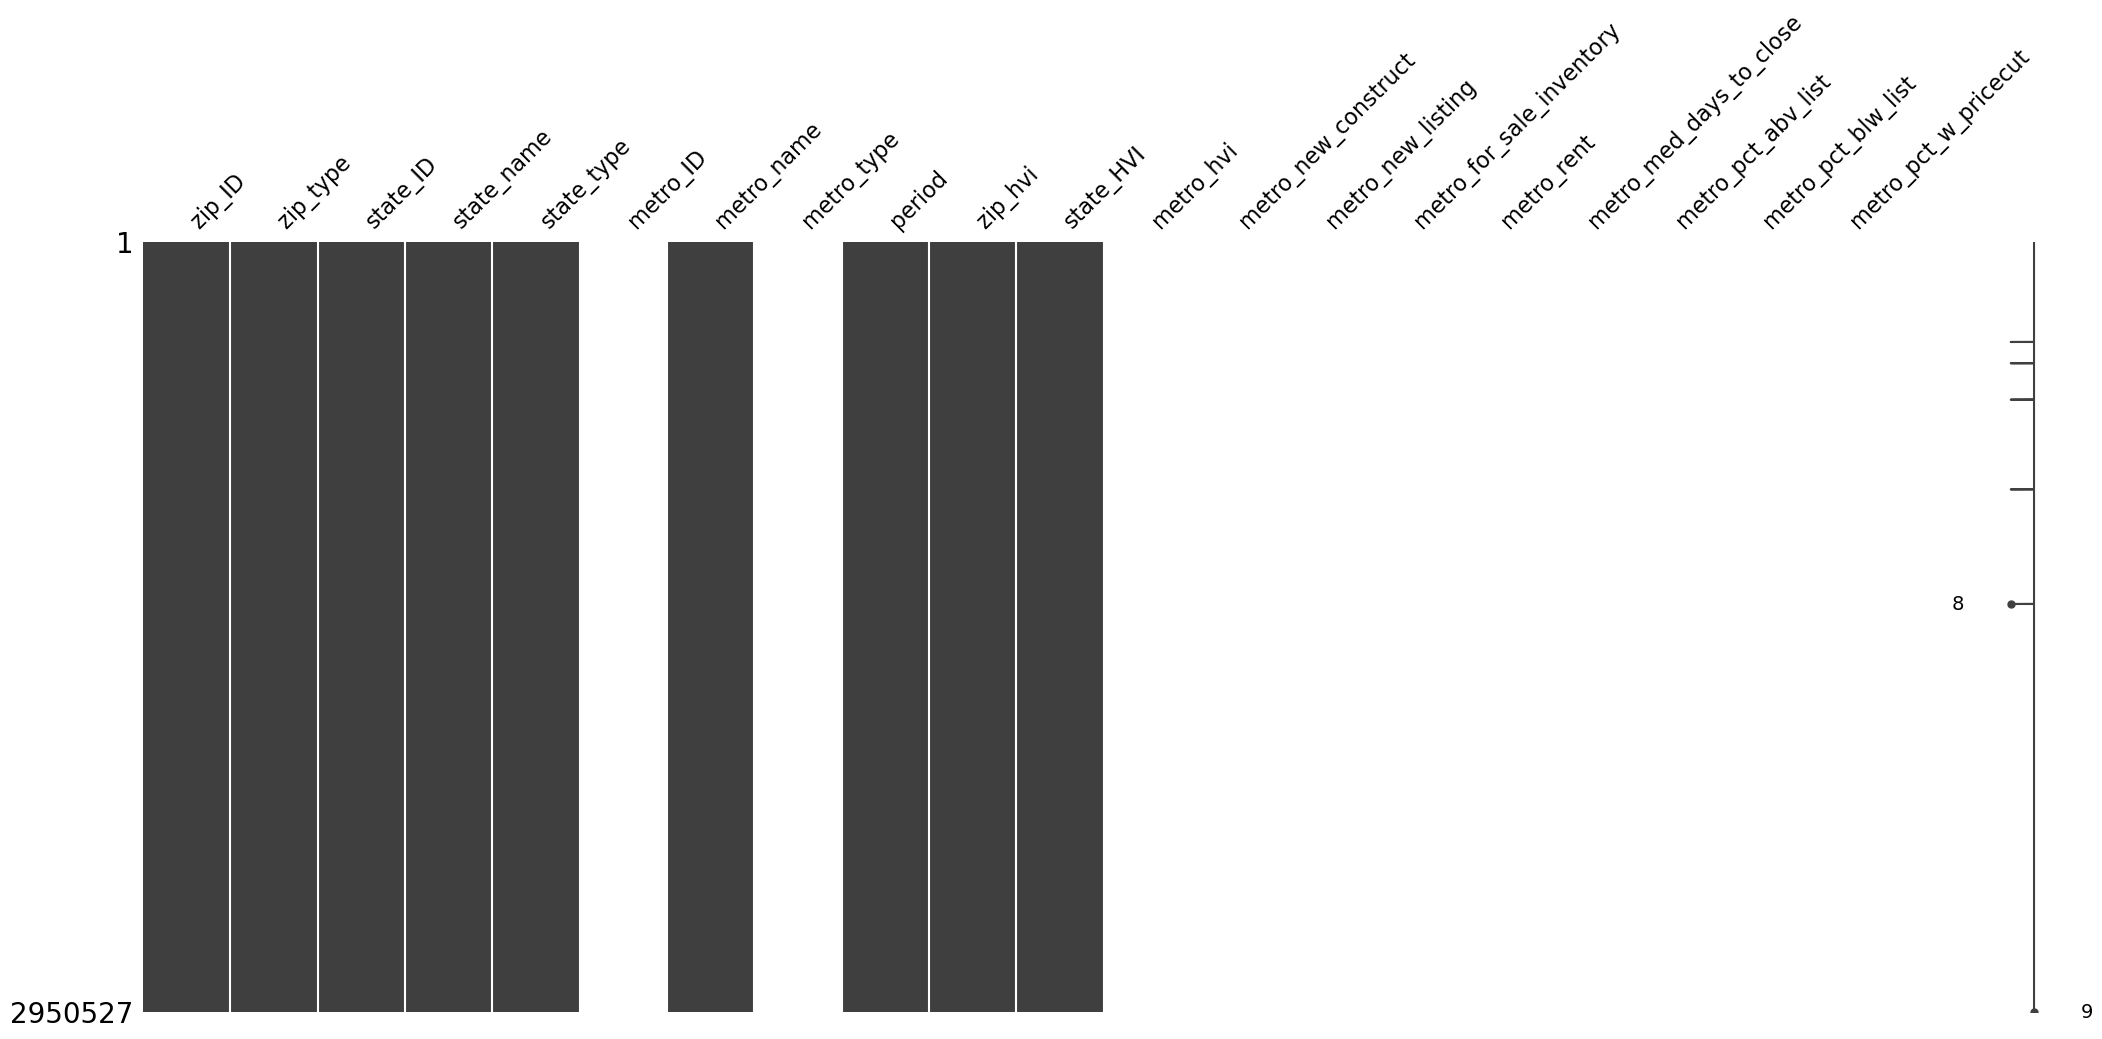

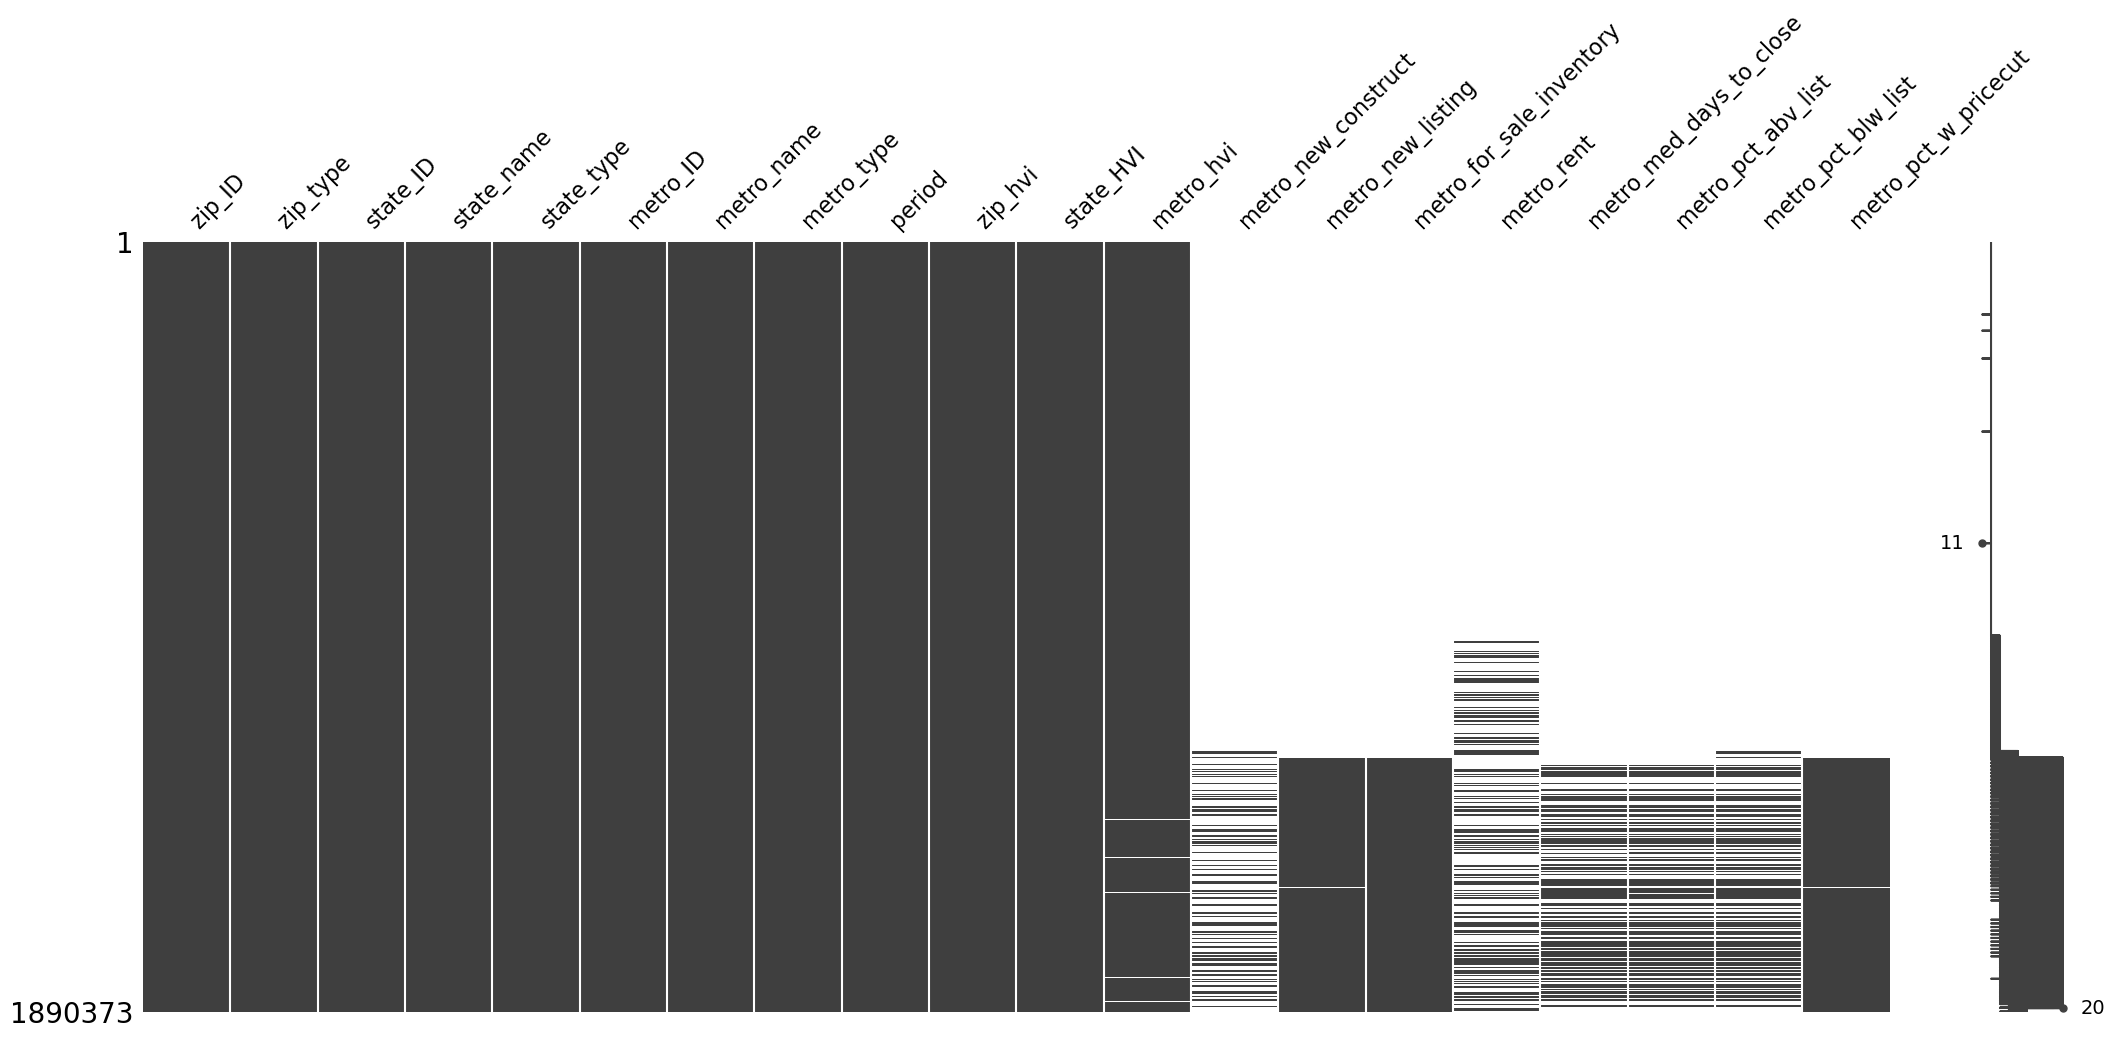

In [38]:
#review missing values seperately depending if metro data was available for merge
print("No metro")
msno.matrix(no_metro_df)

print("Metro")
msno.matrix(metro_df)

In [39]:
new_listing_null = metro_df['metro_new_listing'].isnull()
new_listing_df = metro_df[~new_listing_null]
print("New listing min: ",new_listing_df['period'].min())
print("New listing max: ",new_listing_df['period'].max())

New listing min:  2018-03-31 00:00:00
New listing max:  2024-02-29 00:00:00


Metro data available for more recent years only. Intermiten availability for most fields.
Metro_HVI is consistently available.
Metro_new_listing, metro_for_sale_inventory and metro_pct_w_pricecut appear to be most consistently available beginning March 2018.

**Review missing metro areas and apply fuzzy match where possible**

In [40]:
#Look at one zip code as an example
ATX = zillow_metro_state_zip_clean[zillow_metro_state_zip_clean['zip_ID'] == '78704']
ATX.head()

,zip_ID,zip_type,state_ID,state_name,state_type,metro_ID,metro_name,metro_type,period,zip_hvi,state_HVI,metro_hvi,metro_new_construct,metro_new_listing,metro_for_sale_inventory,metro_rent,metro_med_days_to_close,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut
10465,78704,zip,TX,Texas,state,NaN,"Austin-Round Rock-Georgetown, TX",NaN,2000-01-31,254897.430005,110748.637816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22309,78704,zip,TX,Texas,state,NaN,"Austin-Round Rock-Georgetown, TX",NaN,2000-02-29,258705.932901,110806.075032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34175,78704,zip,TX,Texas,state,NaN,"Austin-Round Rock-Georgetown, TX",NaN,2000-03-31,263462.326298,110833.850686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46060,78704,zip,TX,Texas,state,NaN,"Austin-Round Rock-Georgetown, TX",NaN,2000-04-30,270212.226535,110978.041332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57971,78704,zip,TX,Texas,state,NaN,"Austin-Round Rock-Georgetown, TX",NaN,2000-05-31,277675.976439,111070.229174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#Austin-Round Rock-Georgetown, TX appears to be slightly different than Austin, TX. Fuzzy match needed.
TX = zillow_metro_df_metrics[zillow_metro_df_metrics['StateName'] == "TX"]
TX['RegionName'].unique()

array(['Lubbock, TX', 'Austin, TX', 'Houston, TX', 'Longview, TX',
       'Lufkin, TX', 'Dallas, TX', 'El Paso, TX', 'Texarkana, TX',
       'San Antonio, TX', 'Brownsville, TX', 'Corpus Christi, TX',
       'Beaumont, TX', 'Kerrville, TX', 'McAllen, TX', 'Killeen, TX',
       'Laredo, TX', 'Tyler, TX', 'Midland, TX', 'Waco, TX',
       'College Station, TX', 'Wichita Falls, TX', 'Odessa, TX',
       'Athens, TX', 'Abilene, TX', 'Amarillo, TX', 'Plainview, TX',
       'Nacogdoches, TX', 'Huntsville, TX', 'Stephenville, TX',
       'Del Rio, TX', 'Brownwood, TX', 'Eagle Pass, TX', 'Alice, TX',
       'Kingsville, TX', 'Corsicana, TX', 'Mineral Wells, TX',
       'Jacksonville, TX', 'Paris, TX', 'Gainesville, TX', 'Snyder, TX',
       'Palestine, TX', 'Borger, TX', 'Levelland, TX', 'Bay City, TX',
       'Brenham, TX', 'Fredericksburg, TX', 'Andrews, TX',
       'Rio Grande City, TX', 'Mount Pleasant, TX', 'Sweetwater, TX',
       'Port Lavaca, TX', 'El Campo, TX', 'Vernon, TX', 'Uvalde,

In [42]:
unmatched_metros = list(no_metro_df['metro_name'].unique()) #List of unmatched metros from zip code data
metro_list = list(zillow_metro_df_metrics['RegionName'].unique()) #Unique list of metros from metro data

In [43]:
#Create dictionary with best match for each unmatched metro
matches = {}

for metro in unmatched_metros:
    best_match, score = process.extractOne(metro, metro_list)
    matches[metro] = (best_match, score)
    
print(matches)

{'Auburn-Opelika, AL': ('Auburn, AL', 86), 'Birmingham-Hoover, AL': ('Birmingham, AL', 86), 'Columbus, GA-AL': ('Columbus, GA', 95), 'Daphne-Fairhope-Foley, AL': ('Birmingham, AL', 86), 'Jasper, AL': ('Jasper, AL', 100), 'Fayetteville-Springdale-Rogers, AR': ('Jonesboro, AR', 86), 'Fort Smith, AR-OK': ('Fort Smith, AR', 95), 'Little Rock-North Little Rock-Conway, AR': ('North Port, FL', 86), 'Memphis, TN-MS-AR': ('Memphis, TN', 90), 'Texarkana, TX-AR': ('Texarkana, TX', 95), 'Lake Havasu City-Kingman, AZ': ('Lake Havasu City, AZ', 95), 'Phoenix-Mesa-Chandler, AZ': ('Phoenix, AZ', 86), 'Prescott Valley-Prescott, AZ': ('Prescott Valley, AZ', 95), 'Sierra Vista-Douglas, AZ': ('Phoenix, AZ', 86), 'El Centro, CA': ('El Centro, CA', 100), 'Los Angeles-Long Beach-Anaheim, CA': ('Fresno, CA', 86), 'Madera, CA': ('Madera, CA', 100), 'Oxnard-Thousand Oaks-Ventura, CA': ('Fresno, CA', 86), 'Red Bluff, CA': ('Red Bluff, CA', 100), 'Riverside-San Bernardino-Ontario, CA': ('Fresno, CA', 86), 'Sacram

In [44]:
fuzzy_metro_df = pd.DataFrame(matches).T
filt = fuzzy_metro_df[1] > 86
copy = fuzzy_metro_df[filt].sort_values(by = 1)
copy.head(20)
#Scores greater than 86 appear to be a true match

,0,1
"Myrtle Beach-Conway-North Myrtle Beach, SC-NC","Myrtle Beach, SC",90
"Des Moines-West Des Moines, IA","Des Moines, IA",90
"Charleston-North Charleston, SC","Charleston, SC",90
"Helena-West Helena, AR","Helena, AR",90
"Burlington-South Burlington, VT","Burlington, VT",90
"Memphis, TN-MS-AR","Memphis, TN",90
"Portland-South Portland, ME","Portland, ME",90
"Lafayette-West Lafayette, IN","Lafayette, IN",90
"Lansing-East Lansing, MI","Lansing, MI",90
"Kansas City, MO-KS","Kansas City, MO",95


In [45]:
#Create dictionary with best match for each unmatched metro
matches_filtered = {}

for key, value in matches.items():
    if value[1] > 86:
        matches_filtered[key] = value
    
print(matches_filtered)

{'Columbus, GA-AL': ('Columbus, GA', 95), 'Jasper, AL': ('Jasper, AL', 100), 'Fort Smith, AR-OK': ('Fort Smith, AR', 95), 'Memphis, TN-MS-AR': ('Memphis, TN', 90), 'Texarkana, TX-AR': ('Texarkana, TX', 95), 'Lake Havasu City-Kingman, AZ': ('Lake Havasu City, AZ', 95), 'Prescott Valley-Prescott, AZ': ('Prescott Valley, AZ', 95), 'El Centro, CA': ('El Centro, CA', 100), 'Madera, CA': ('Madera, CA', 100), 'Red Bluff, CA': ('Red Bluff, CA', 100), 'Worcester, MA-CT': ('Worcester, MA', 95), 'Dover, DE': ('Dover, DE', 100), 'Salisbury, MD-DE': ('Salisbury, MD', 95), 'Ocala, FL': ('Ocala, FL', 100), 'Calhoun, GA': ('Calhoun, GA', 100), 'Chattanooga, TN-GA': ('Chattanooga, TN', 95), 'Cornelia, GA': ('Cornelia, GA', 100), 'Eufaula, AL-GA': ('Eufaula, AL', 95), 'Jefferson, GA': ('Jefferson, GA', 100), 'LaGrange, GA-AL': ('LaGrange, GA', 95), 'Milledgeville, GA': ('Milledgeville, GA', 100), 'Ames, IA': ('Ames, IA', 100), 'Carroll, IA': ('Carroll, IA', 100), 'Des Moines-West Des Moines, IA': ('Des 

In [46]:
no_metro_df

,zip_ID,zip_type,state_ID,state_name,state_type,metro_ID,metro_name,metro_type,period,zip_hvi,state_HVI,metro_hvi,metro_new_construct,metro_new_listing,metro_for_sale_inventory,metro_rent,metro_med_days_to_close,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut
13,36801,zip,AL,Alabama,state,NaN,"Auburn-Opelika, AL",NaN,2000-01-31,1.036514e+05,96628.198952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,36804,zip,AL,Alabama,state,NaN,"Auburn-Opelika, AL",NaN,2000-01-31,1.380397e+05,96628.198952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,36830,zip,AL,Alabama,state,NaN,"Auburn-Opelika, AL",NaN,2000-01-31,1.495622e+05,96628.198952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,36832,zip,AL,Alabama,state,NaN,"Auburn-Opelika, AL",NaN,2000-01-31,1.594775e+05,96628.198952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,36870,zip,AL,Alabama,state,NaN,"Auburn-Opelika, AL",NaN,2000-01-31,9.385150e+04,96628.198952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840846,26865,zip,WV,West Virginia,state,NaN,"Winchester, VA-WV",NaN,2024-02-29,2.901040e+05,155333.089031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4840873,83001,zip,WY,Wyoming,state,NaN,"Jackson, WY-ID",NaN,2024-02-29,2.348668e+06,333745.049940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4840874,83013,zip,WY,Wyoming,state,NaN,"Jackson, WY-ID",NaN,2024-02-29,1.550382e+06,333745.049940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4840875,83014,zip,WY,Wyoming,state,NaN,"Jackson, WY-ID",NaN,2024-02-29,4.363572e+06,333745.049940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#Add fuzzy match to dataframe
fuzzy_metro_name = {k:v[0] for k, v in matches_filtered.items()}
fuzzy_score = {k:v[1] for k, v in matches_filtered.items()}

no_metro_df['fuzzy_metro_name'] = no_metro_df['metro_name'].map(fuzzy_metro_name)
no_metro_df['fuzzy_score'] = no_metro_df['metro_name'].map(fuzzy_score)

In [48]:
#Replace metro name with fuzzy name
print(no_metro_df.shape)
no_metro_df_temp1 = no_metro_df

print(no_metro_df_temp1['fuzzy_metro_name'].isnull().sum())
no_fuzzy_match = no_metro_df_temp1['fuzzy_metro_name'].isnull() 
no_metro_df_temp1.loc[no_fuzzy_match, 'fuzzy_metro_name'] = no_metro_df_temp1.loc[no_fuzzy_match, 'metro_name']
print(no_metro_df_temp1['fuzzy_metro_name'].isnull().sum())

#Update column names
no_metro_df_temp1 = no_metro_df.reset_index()
no_metro_df_temp1.drop(columns=['index','metro_name'], inplace=True)
no_metro_df_temp1.rename(columns={'fuzzy_metro_name':'metro_name'}, inplace=True)

print(no_metro_df_temp1.shape)
no_metro_df_temp1.columns

(2950527, 22)
2484415
0
(2950527, 21)


Index(['zip_ID', 'zip_type', 'state_ID', 'state_name', 'state_type',
       'metro_ID', 'metro_type', 'period', 'zip_hvi', 'state_HVI', 'metro_hvi',
       'metro_new_construct', 'metro_new_listing', 'metro_for_sale_inventory',
       'metro_rent', 'metro_med_days_to_close', 'metro_pct_abv_list',
       'metro_pct_blw_list', 'metro_pct_w_pricecut', 'metro_name',
       'fuzzy_score'],
      dtype='object')

In [49]:
#Remerge metro dataset with fuzzy metro name
no_metro_df_temp = pd.merge(
    no_metro_df_temp1[['zip_ID', 'zip_type', 'state_ID', 'state_name', 'state_type', #exclude metro metrics from no_metro_df
       'metro_ID', 'metro_name', 'metro_type', 'period', 'zip_hvi',
       'state_HVI', 'fuzzy_score']],
    zillow_metro_df_metrics,
    left_on=['metro_name','period'],right_on=['RegionName','variable'],how='inner')

no_metro_df_updated = no_metro_df_temp.drop(columns=['metro_ID','metro_name','metro_type','StateName','variable'])
no_metro_df_updated = no_metro_df_updated.rename(columns={
    "RegionID":"metro_ID",
    "RegionName":"metro_name",
    "RegionType":"metro_type"
})
print(no_metro_df_updated['fuzzy_score'].unique())
print(no_metro_df_updated.shape)

[95. 90.]
(407185, 21)


In [50]:
#Identify records from no_metro_df that have been dropped
unmatched_index_left = no_metro_df_temp1.index.difference(no_metro_df_updated.index)
no_metro_df_no_update = no_metro_df_temp1.loc[unmatched_index_left]
no_metro_df_no_update.shape
print(len(unmatched_index_left))
print(len(no_metro_df_updated))
print(len(no_metro_df))

2543342
407185
2950527


In [51]:
zillow_data = pd.concat([metro_df, no_metro_df_updated, no_metro_df_no_update], ignore_index=True)

In [52]:
print("Updated Zillow dataframe includes same record count: ",len(zillow_data) == len(zillow_metro_state_zip_clean))

Updated Zillow dataframe includes same record count:  True


*****
**Review data sample and save**
*****

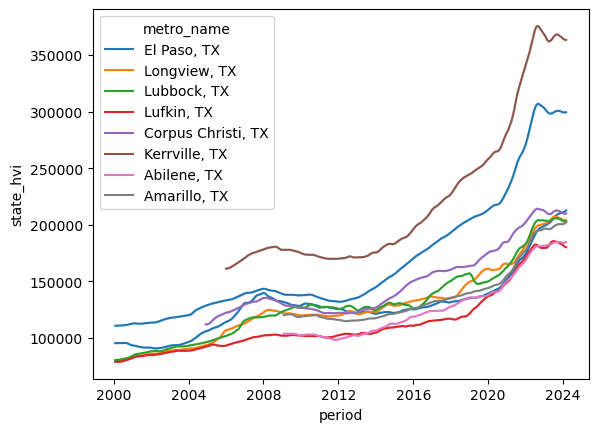

In [58]:
#Review metro hvi for 8 metros in Texas
z_TX = zillow_data[zillow_data['state_ID'] == 'TX']
z_TX_metros = z_TX['metro_name'].unique()
first8 = z_TX_metros[:8]
z_TX_first8 = z_TX[z_TX['metro_name'].isin(first8)]
sns.lineplot(x='period', y='metro_hvi', hue='metro_name', data=z_TX_first8)
plt.show()

In [54]:
zillow_data.T

,0,1,2,3,4,5,6,7,8,9,...,4840890,4840891,4840892,4840893,4840894,4840895,4840896,4840897,4840898,4840899
zip_ID,99501,99502,99503,99504,99507,99508,99515,99516,99517,99518,...,26757,26761,26763,26808,26817,26865,83001,83013,83014,83414
zip_type,zip,zip,zip,zip,zip,zip,zip,zip,zip,zip,...,zip,zip,zip,zip,zip,zip,zip,zip,zip,zip
state_ID,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,...,WV,WV,WV,WV,WV,WV,WY,WY,WY,WY
state_name,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,...,West Virginia,West Virginia,West Virginia,West Virginia,West Virginia,West Virginia,Wyoming,Wyoming,Wyoming,Wyoming
state_type,state,state,state,state,state,state,state,state,state,state,...,state,state,state,state,state,state,state,state,state,state
metro_ID,394327,394327,394327,394327,394327,394327,394327,394327,394327,394327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metro_name,"Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK","Anchorage, AK",...,"Winchester, VA","Winchester, VA","Winchester, VA","Winchester, VA","Winchester, VA","Winchester, VA","Jackson, WY","Jackson, WY","Jackson, WY","Jackson, WY"
metro_type,msa,msa,msa,msa,msa,msa,msa,msa,msa,msa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
period,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,2000-01-31 00:00:00,...,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00
zip_hvi,143597.65168,146161.464449,116638.267029,127798.357542,148395.120638,129209.004222,161361.575055,225197.933382,132476.113349,118899.76077,...,198687.716776,229702.475199,207892.24297,246882.296118,264390.01286,290104.045305,2348667.697142,1550381.620132,4363572.183586,1661719.934634


In [55]:
zillow_data.rename(columns={"state_HVI":"state_hvi"},inplace=True)

In [56]:
zillow_data.to_pickle('../Data/zillow_data.pkl')